# Notebook de Implementación - Differencial Privacy (V1)
__Contacto:__ Gabriel Pila <br>
__Email:__ gabriel.pilah@pucp.edu.pe

# 1) IBM - Differential Privacy Library

In [ ]:
# !pip install diffprivlib

In [1238]:
## Carga de librerías
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB # GaussianNB de diffprivlib
from sklearn.naive_bayes import GaussianNB as GaussianNBsk # GaussianNB de sklearn

In [1239]:
dataset = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.2)

X_train_b = X_train.copy()
y_train_b = y_train.copy()
X_test_b = X_test.copy()
y_test_b = y_test.copy()

__Training with SkLearn__

In [1260]:
#### Entrenamiento con GaussianNB de Sklearn
epsilons = np.logspace(-2, 2, 50)
accuracy_sk = list()

for epsilon in epsilons:
    clf = GaussianNBsk()
    clf.fit(X_train, y_train)
    
    accuracy_sk.append(clf.score(X_test, y_test))

# plt.semilogx(epsilons, accuracy_sk)
# plt.title("Differentially private Naive Bayes accuracy")
# plt.xlabel("epsilon")
# plt.ylabel("Accuracy")
# plt.show()
# # plt.

__Training with Diffprivlib__

In [1249]:
# Fit predict de un modelo con DP (se observa que los resultados varían con cada corrida)
clf = GaussianNB()
clf.fit(X_train, y_train)

clf.predict(X_test)

print(f'Test accuracy: {clf.score(X_test, y_test):.02f}')

Test accuracy: 0.50


C:\ProgramData\Anaconda3\lib\site-packages\diffprivlib\models\naive_bayes.py:100: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "


__Probando Epsilon - 1 ronda__

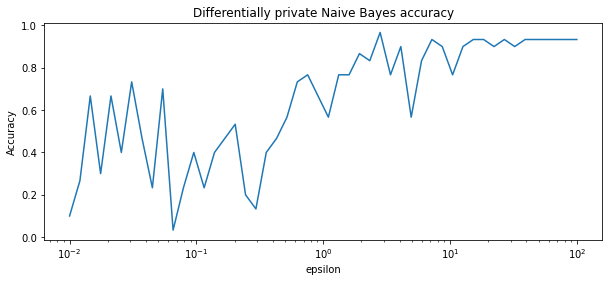

In [1261]:
######## 1 ronda del modelo por cada epsilon --> Demasiado ruido #############

epsilons = np.logspace(-2, 2, 50)
bounds = ([4.3, 2.0, 1.1, 0.1], [7.9, 4.4, 6.9, 2.5])
accuracy = list()

for epsilon in epsilons:
    clf = GaussianNB(bounds=bounds, epsilon=epsilon)
    clf.fit(X_train, y_train)
    
    accuracy.append(clf.score(X_test, y_test))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private Naive Bayes accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()

__Probando Epsilon - 50 rondas__

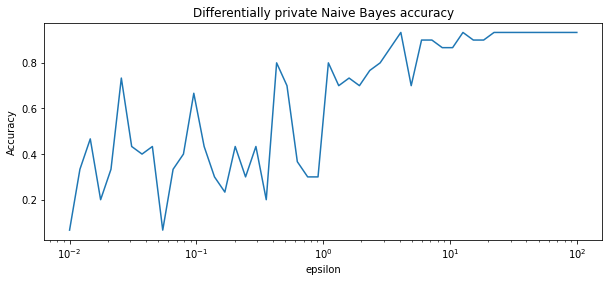

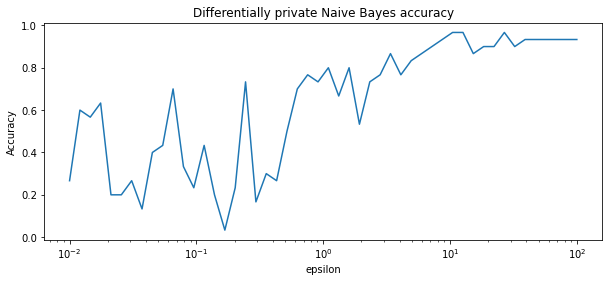

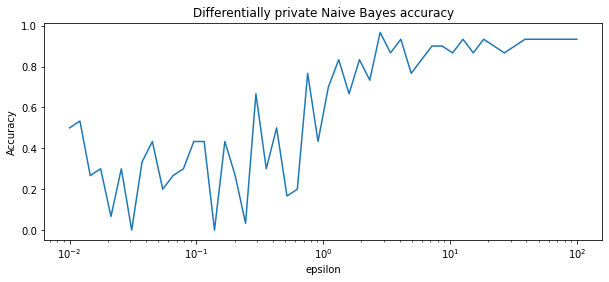

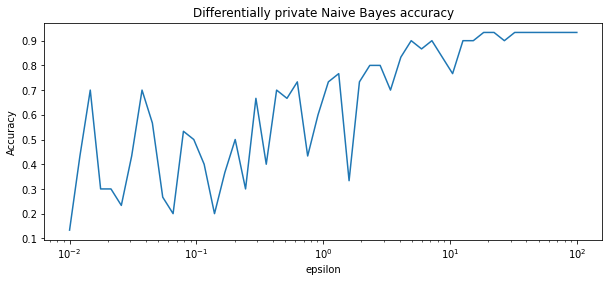

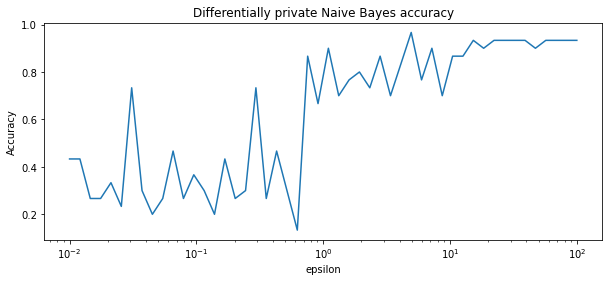

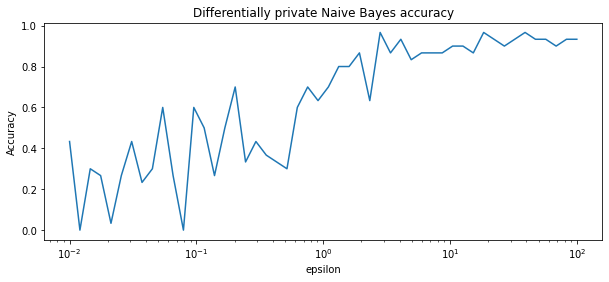

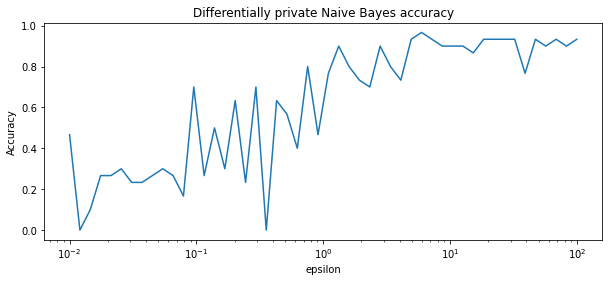

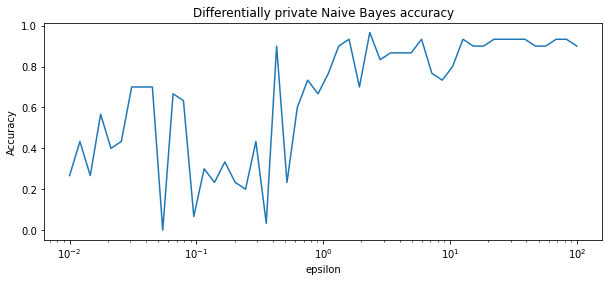

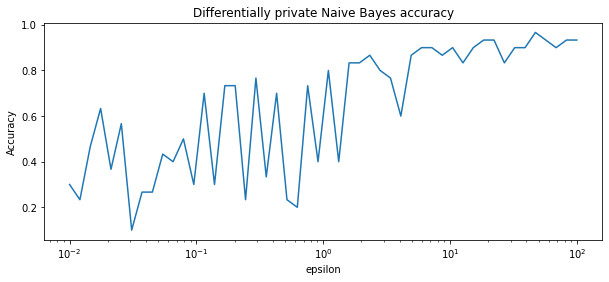

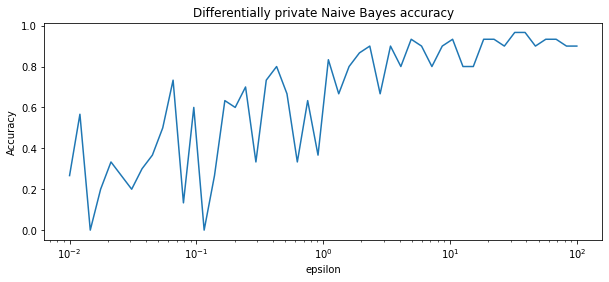

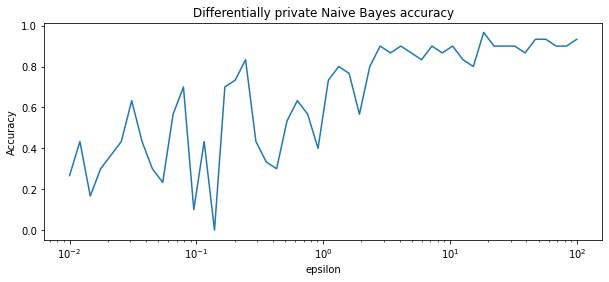

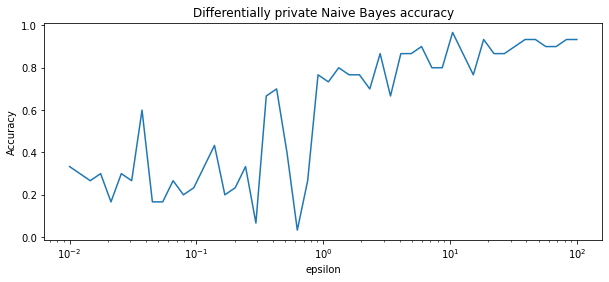

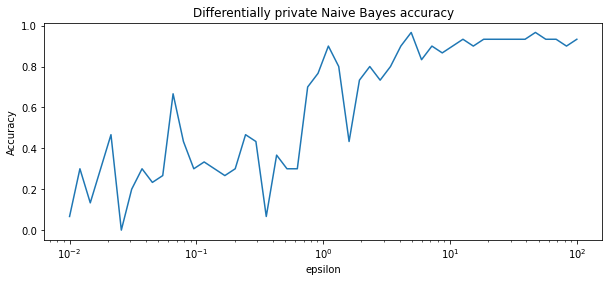

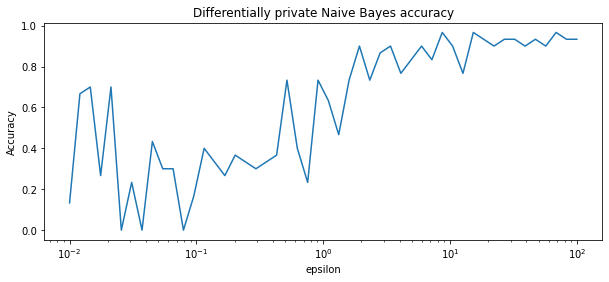

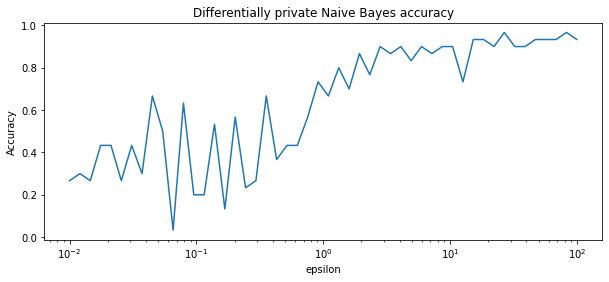

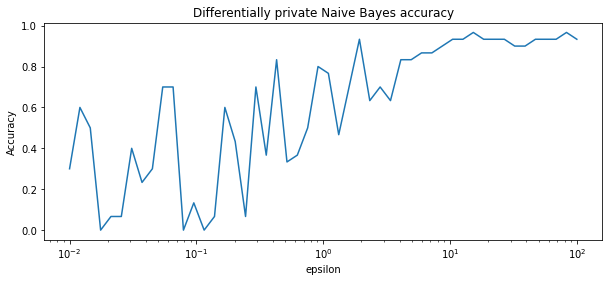

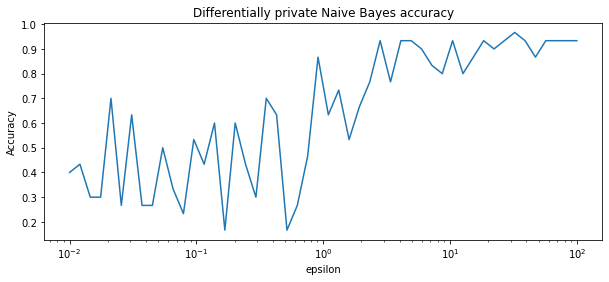

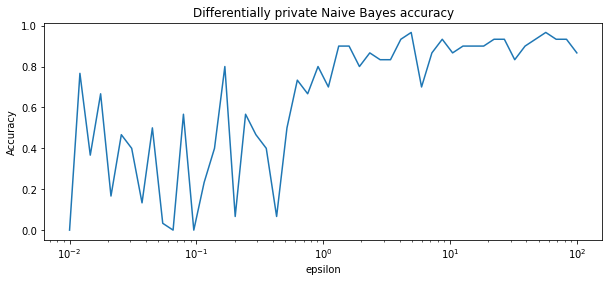

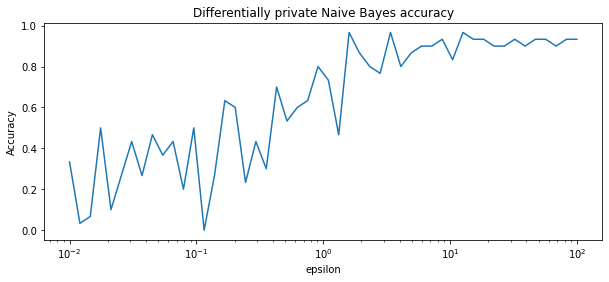

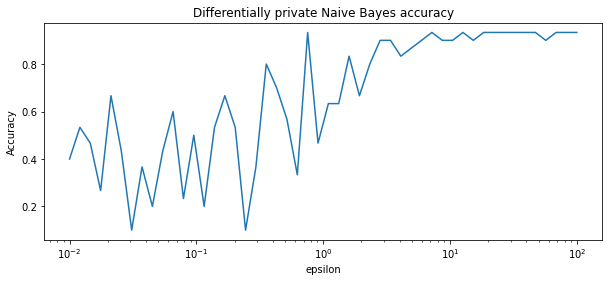

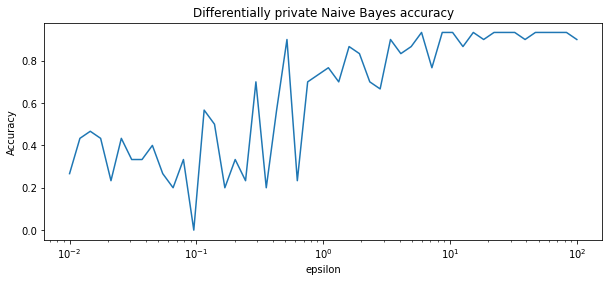

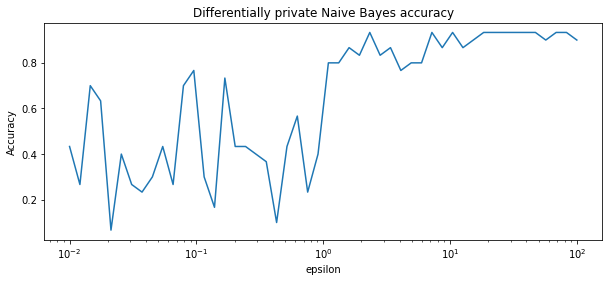

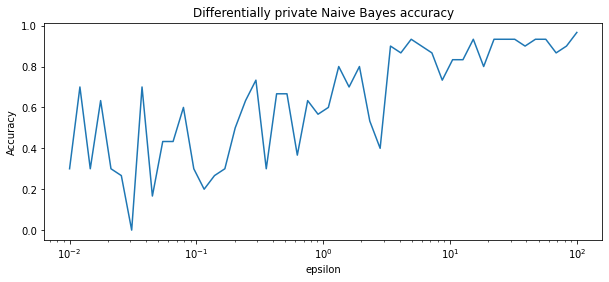

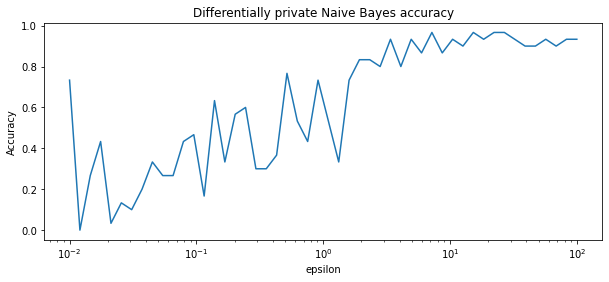

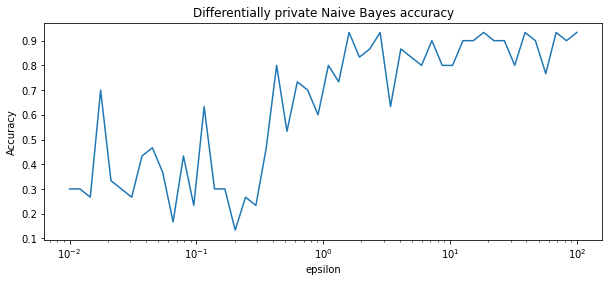

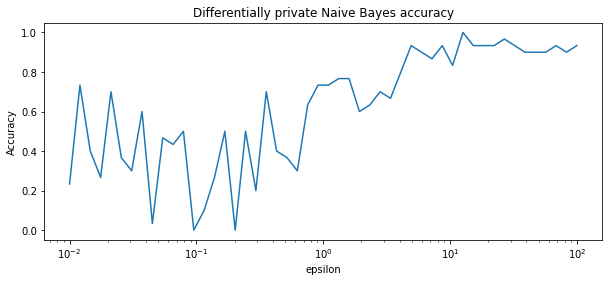

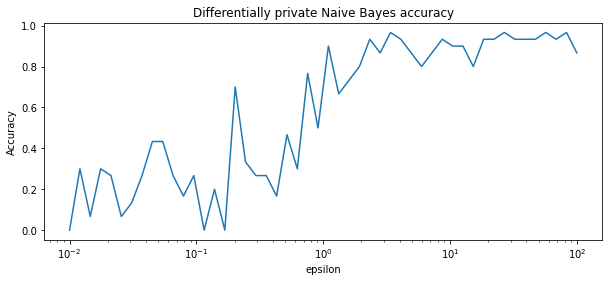

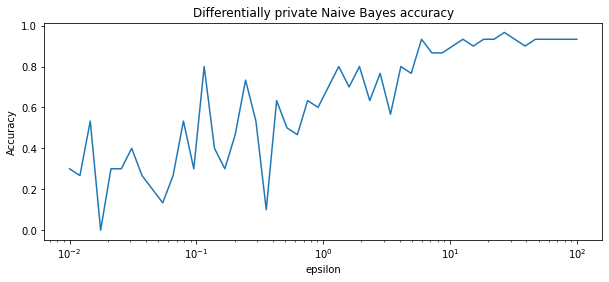

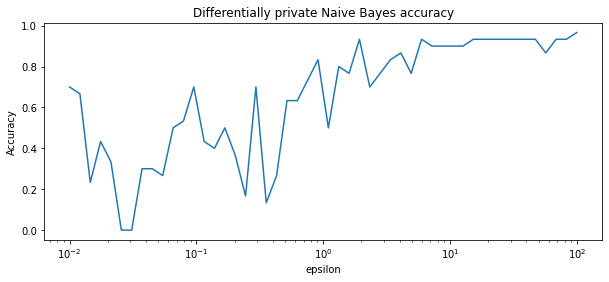

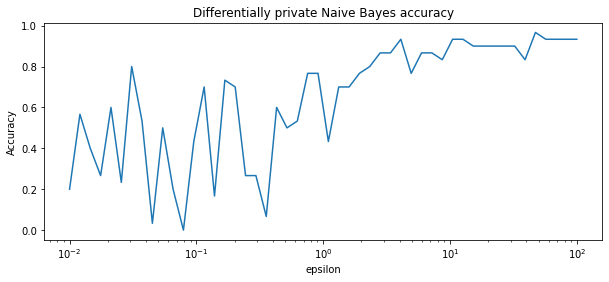

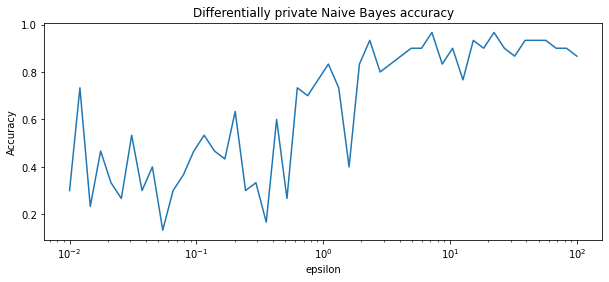

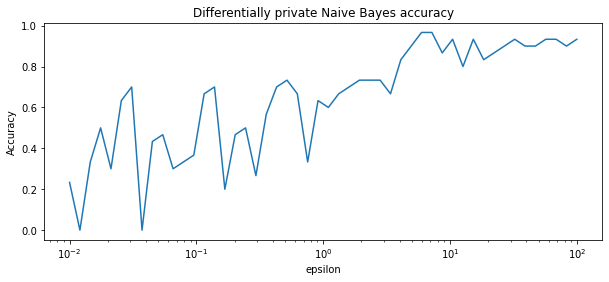

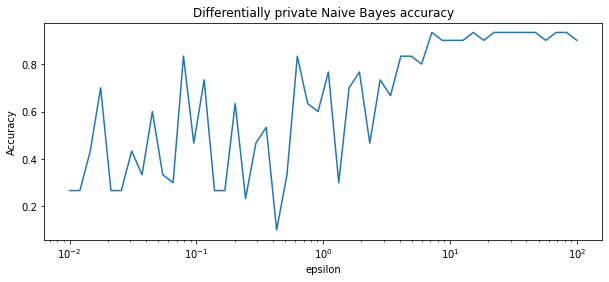

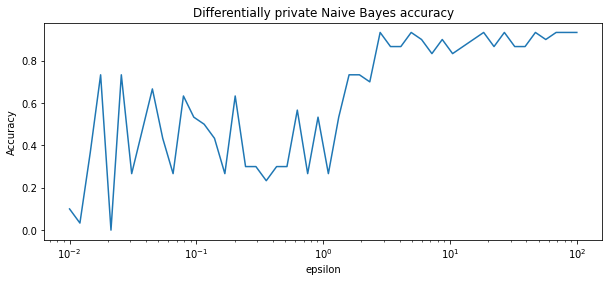

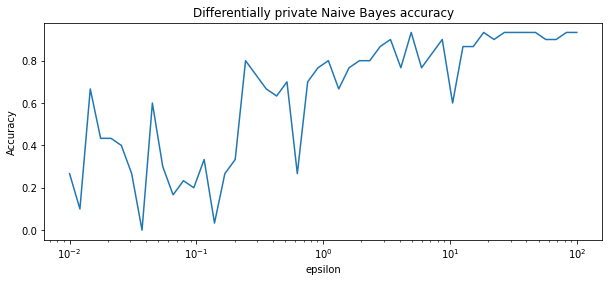

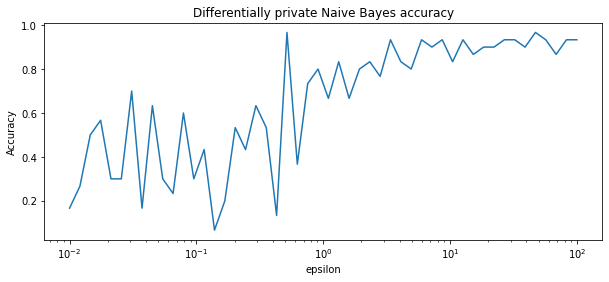

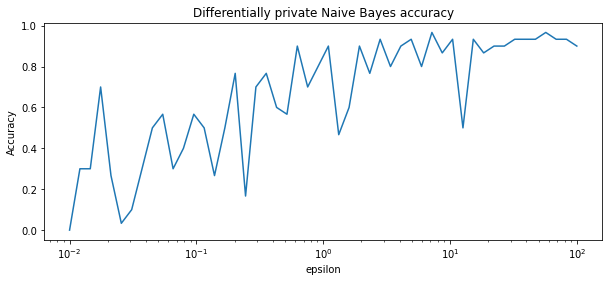

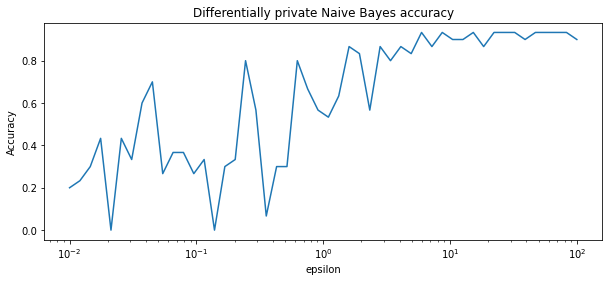

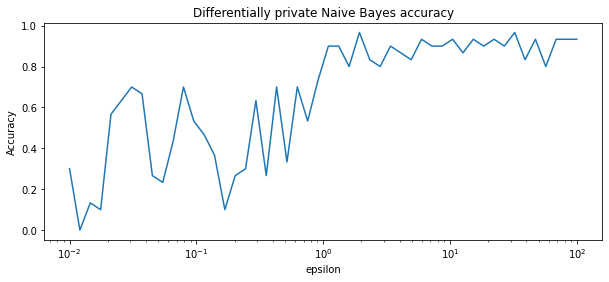

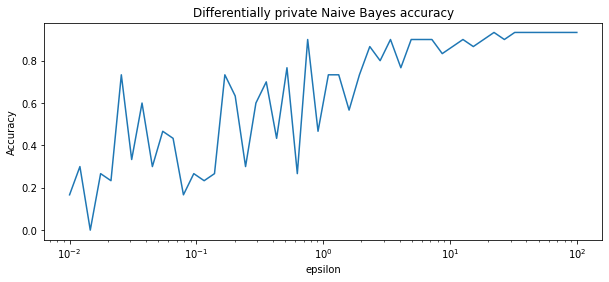

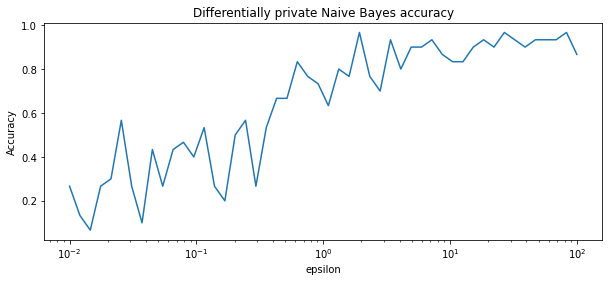

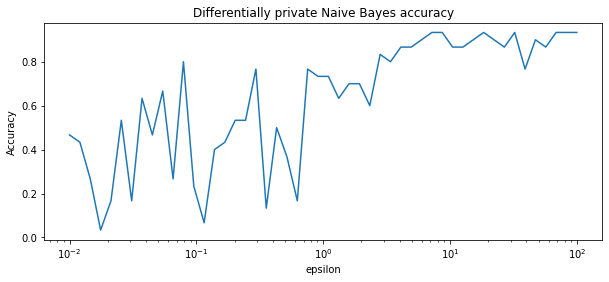

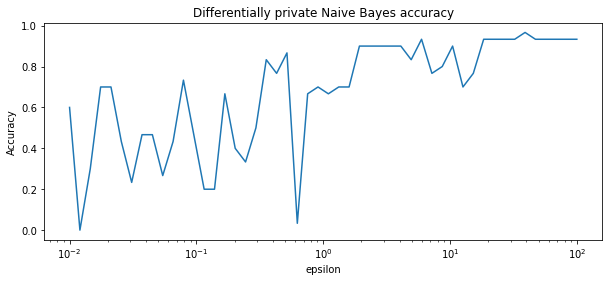

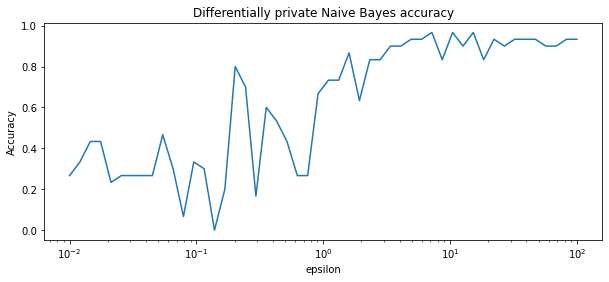

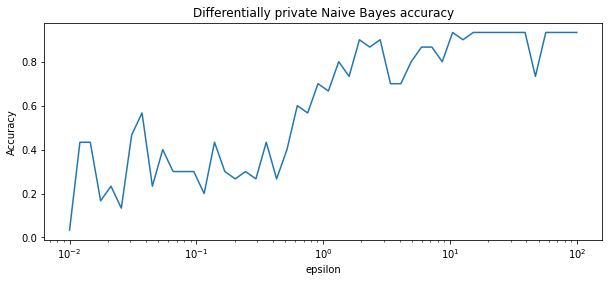

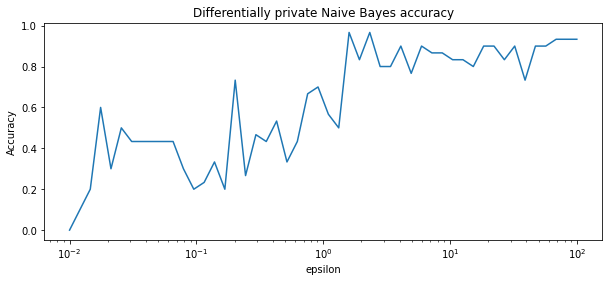

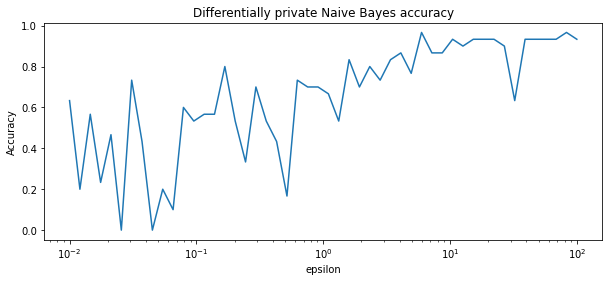

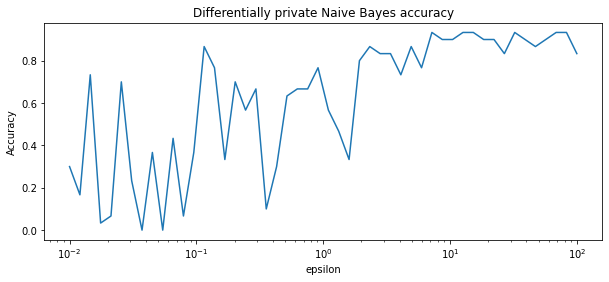

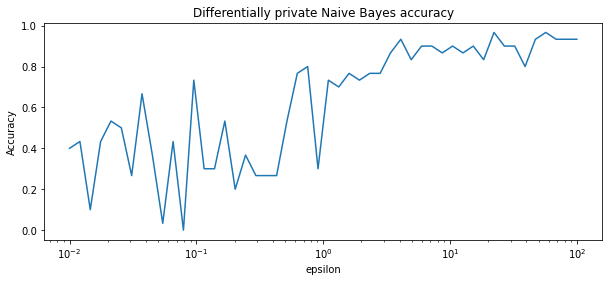

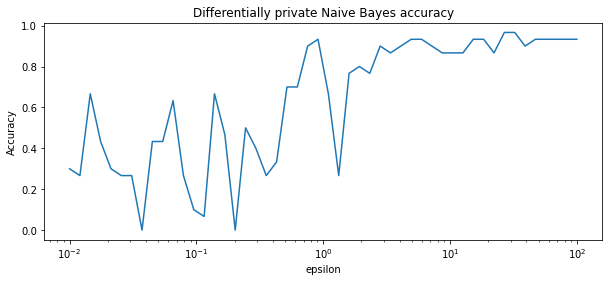

In [1266]:
# Generación de 50 rondas de prediccion
data = []
for i in range(50):
    epsilons = np.logspace(-2, 2, 50)
    bounds = ([4.3, 2.0, 1.1, 0.1], [7.9, 4.4, 6.9, 2.5])
    accuracy = list()

    for epsilon in epsilons:
        clf = GaussianNB(bounds=bounds, epsilon=epsilon)
        clf.fit(X_train, y_train)

        accuracy.append(clf.score(X_test, y_test))
    
    data.append((epsilons, accuracy))
    plt.semilogx(epsilons, accuracy)
    plt.title("Differentially private Naive Bayes accuracy")
    plt.xlabel("epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    
# Consolidación del accuracy de predicciones de las 50 rondas
df_data_diffprivlib = pd.DataFrame()
for dat in data:
    df_i = pd.DataFrame(dat[1], index=dat[0]).T
    df_data_diffprivlib = df_data_diffprivlib.append(df_i)

__Plotteo de SkLearn vs Diffprivlib (50 rondas) para modelo GaussianNB__

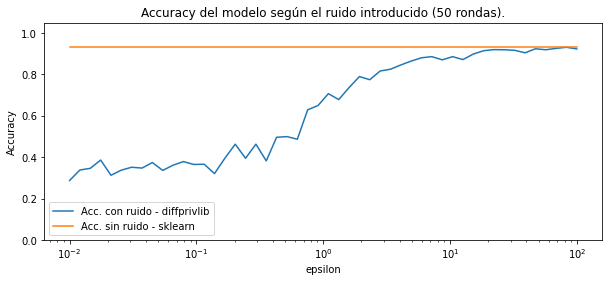

In [1274]:
## Sklearn vs Diffprivlib

# Diffprivlib
df_data_diffprivlib.mean().plot().set(xscale='log')
# Sklearn
plt.semilogx(epsilons, accuracy_sk)

plt.title("Accuracy del modelo según el ruido introducido (50 rondas).")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.legend(['Acc. con ruido - diffprivlib','Acc. sin ruido - sklearn'])
plt.ylim(0,1.05)
plt.show()

# 2) Paper Implementation
## Choosing epsilon for differencial privacy - 2011 – Jaewoo Lee


In [1275]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

In [1276]:
plt.rcParams['figure.figsize'] = [16, 4]

In [1277]:
data = pd.DataFrame({'name':['Chris','Kelly','Pat','Terry'],
              'school_year':[1,2,3,4],
              'absence_days':[1,2,3,10]})
data

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


In [806]:
#### Sensitivity
def get_sensitivity_from_serie(serie:tuple, query:str='mean'):
    """Devuelve la sensitividad a partir de la serie de valores y el query introducido.
    Args:
        serie: [tuple/list] Valores de la columna a analizar (Base X, que se comparará a Base X-1 elemento)
        query: [str] Consulta a la serie. Acepta metodos de numpy (mean/median/max/min/count_nonzero/std/var)
    Returns: tuple
        k: resultado de la consulta
        k_is: resultado de las consultas de n-1 elementos
        sensitivity: sensitividad calculada
    """
    serie = list(serie)
    combina = [x for x in itertools.combinations(serie, len(serie)-1)]
    k = eval(f'np.{query}({serie})')
    k_is = [eval(f'np.{query}({x})') for x in combina]
    sensitivity = max([abs(ki-k) for ki in k_is])
    return k, k_is, sensitivity    

def get_global_sensitivity_from_series(serie_total, n=3, query='mean'):
    """Devuelve la sensitividad global a partir de las series de valores quitando 1 sample de la serie global y el query introducido.
    Args:
        serie_total: [tuple/list] Serie total (a partir de la que saldrán las diferentes combinaciones de las que saldrá la sensitividad)
        query: [str] Consulta a la serie. Acepta metodos de numpy (mean/median/max/min/count_nonzero/std/var)
    Returns: tuple
        global_sensitivity: sensitividad máxima
    """
    sensitivities_options = []

    feat_values = serie_total.to_list()
    combinations = [x for x in itertools.combinations(feat_values, n)]

    for combo in combinations:
        _,__,sensitiv_i = get_sensitivity_from_serie(serie=combo, query=query)
        sensitivities_options.append(sensitiv_i)

    global_sensitivity = max(sensitivities_options)
    return combinations, global_sensitivity

In [1280]:
#### Laplacian Response

def get_laplace_noise(mean=0, scale=1):
    return np.random.laplace(loc=mean, scale=scale)

def plot_random_samples_laplace(n=10000, mean=0, scale=1, plot=False, return_value=False, label=''):
    values = []
    for i in range(n):
        value = get_laplace_noise(mean=mean, scale=scale)
        values.append(value)
    if plot:
        sns.distplot(values, hist=False, label=label)
    if return_value:
        return values

In [551]:
#### Laplacian Plot

def get_pdf_laplacian(x=0, mean=0, scale=1):
    coef = 1/(2*scale)
    exp = abs(x-mean)/scale
    return coef * np.exp(-exp)

def plot_variations_w_epsilon(epsilon=0.3, combinations=[(1,0),(2,0)], query='mean', xlim=(-10,10)):
    '''Plot variación
    Args.
        epsilon: privacy parameter or the privacy budget
        combinations: conjunto de series en las que se puede iterar
        query: consulta que se desea hacer a la base
    '''
    print(f'epsilon_value:\t\t {epsilon}')
    sensitivities = []
    for combo in combinations:
        _,__,sensitivity = get_sensitivity_from_serie(serie=combo, query=query)
        sensitivities.append(sensitivity)
    global_sensitivity = max(sensitivities)
    print(f'global_sensitivity:\t {global_sensitivity}\n')
        
    for combo in combinations:
        gamma_real = eval(f'np.{query}({combo})')
        print(f'{combo}\t-->\tquery={query} | gamma = {gamma_real:.02f}')
        laplacian_val = plot_random_samples_laplace(n=10000, 
                                                   mean=gamma_real, 
                                                   scale=global_sensitivity/epsilon, 
                                                   plot=True, 
                                                   label=f'gamma = {gamma_real:.02f}')
        plt.axvline(x=gamma_real, ymin=0, ymax=1, c='black', ls='--')
    plt.xlim(xlim)
    plt.xticks(np.arange(xlim[0], xlim[1]+1, 1.0))
    plt.title(f'query = {query} | | epsilon = {epsilon}')

In [779]:
#### Laplacian Plots

def get_posterior_table(epsilon_list:list=[5,2,1,0.1,0.01], combinations=[(0,1),(0,2)], real_value=2, query='mean'):
    posterior_table = {}
    
    sensitivities = []
    for combo in combinations:
        _,__,sensitivity = get_sensitivity_from_serie(serie=combo, query=query)
        sensitivities.append(sensitivity)
    global_sensitivity = max(sensitivities)
    print(f'global_sensitivity:\t {global_sensitivity}\n')

    for epsilon in epsilon_list:
        pdfs = []
        combos = []
    
        for i, combo in enumerate(combinations):
            combos.append(str(combo))
            gamma_real = eval(f'np.{query}({combo})')
            pdf_combo = get_pdf_laplacian(x=real_value,
                                          mean=gamma_real,
                                          scale=global_sensitivity/epsilon)
            pdfs.append(pdf_combo)
        pdfs = np.array(pdfs)
        posterior = pdfs / pdfs.sum()

        posterior_table[f'epsilon={epsilon}'] = posterior
    
    print(f'Valor real = {real_value}')
    tabla_resultado = pd.DataFrame(posterior_table, index=combos)
    
    posterior_df = pd.DataFrame(tabla_resultado.max(axis=0)-1/len(combinations), columns=['guess_confidence']).T
    tabla_resultado = tabla_resultado.append(posterior_df)
    
    return tabla_resultado

In [659]:
# Valores del paper: factor de escala

combinations, global_sensitivity = get_global_sensitivity_from_series(data['absence_days'], n=3, query='mean')

epsilon = 2

scale_factor = global_sensitivity / epsilon
scale_factor

1.4166666666666665

In [1279]:
## Prueba de respuesta random del paper
## Caso 1: Mean = 2. Se introduce un factor laplaciano y el epsilon generado debe de ser menor a 2
response = 2
response_w_noise = response + get_laplace_noise(0,scale=scale_factor)
response_w_noise = abs(response_w_noise)

numerator = np.mean([1 if np.mean(x) > response_w_noise else 0 for x in combinations])
print(f'numerator:\t{numerator}')

denominator = np.mean([1 if response_w_noise > z else 0 for z in np.array([[np.mean(y) for y in itertools.combinations(x, 2)] for x in combinations]).reshape(1,-1)[0] ])
print(f'denominator:\t{denominator}')

probabilidad = numerator/denominator
print(f'probabilidad:\t{probabilidad}')

dp_epsilon = np.log(probabilidad)
print(f'dp_epsilon:\t{dp_epsilon}')

numerator:	0.75
denominator:	0.5
probabilidad:	1.5
dp_epsilon:	0.4054651081081644


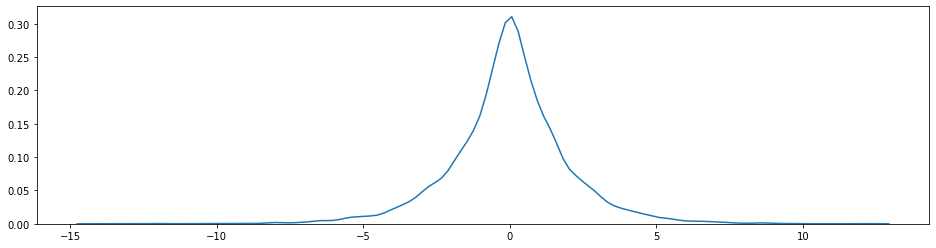

In [1110]:
# Laplacian random noise
get_random_samples_laplace(scale=2.8333333/2,n=10000, plot=True)

### MEAN query for different epsilon values

epsilon_value:		 20
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


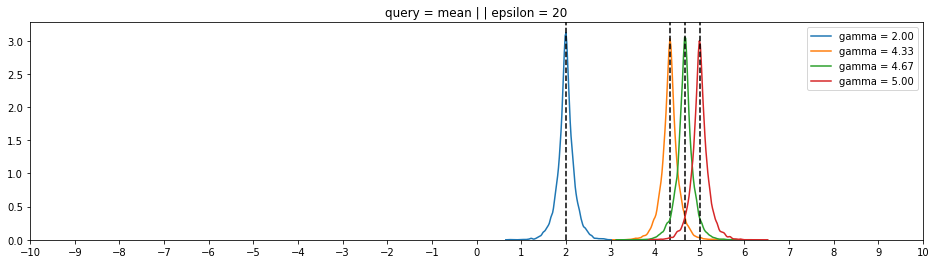

In [1096]:
plot_variations_w_epsilon(epsilon=20, combinations=combinations, query='mean')

epsilon_value:		 5
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


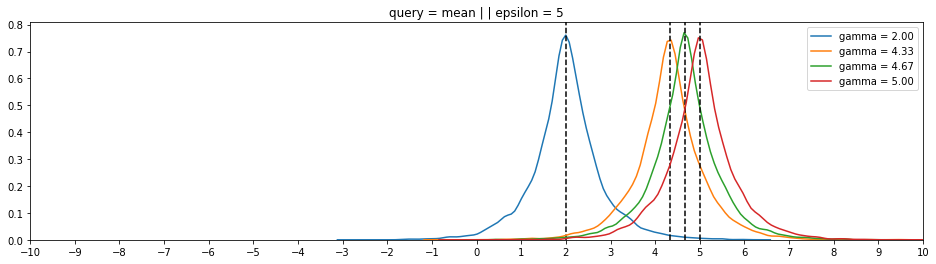

In [834]:
plot_variations_w_epsilon(epsilon=5, combinations=combinations, query='mean')

epsilon_value:		 2
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


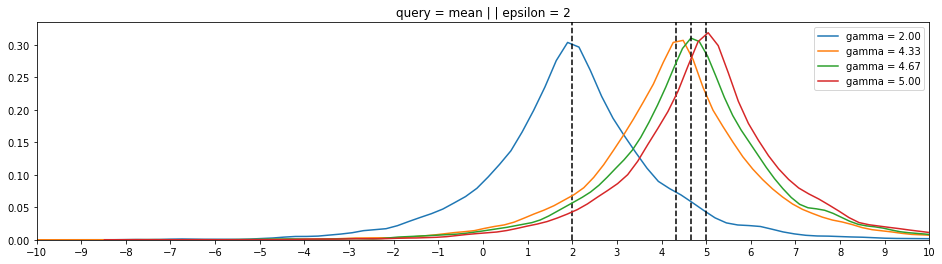

In [748]:
plot_variations_w_epsilon(epsilon=2, combinations=combinations, query='mean')

epsilon_value:		 1
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


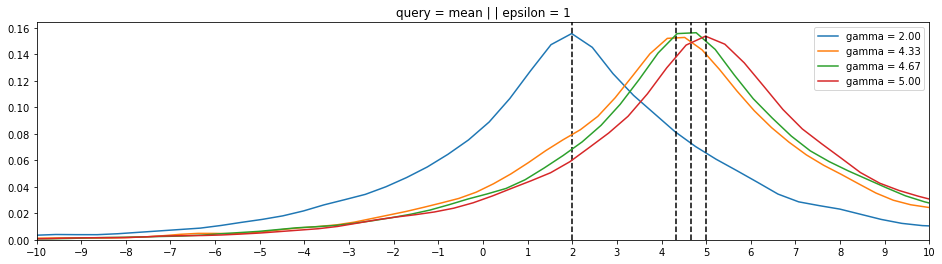

In [749]:
plot_variations_w_epsilon(epsilon=1, combinations=combinations, query='mean')

epsilon_value:		 0.5
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


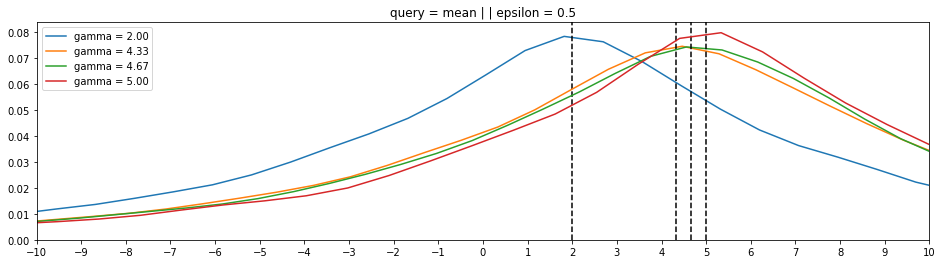

In [750]:
plot_variations_w_epsilon(epsilon=0.5, combinations=combinations, query='mean')

epsilon_value:		 0.1
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


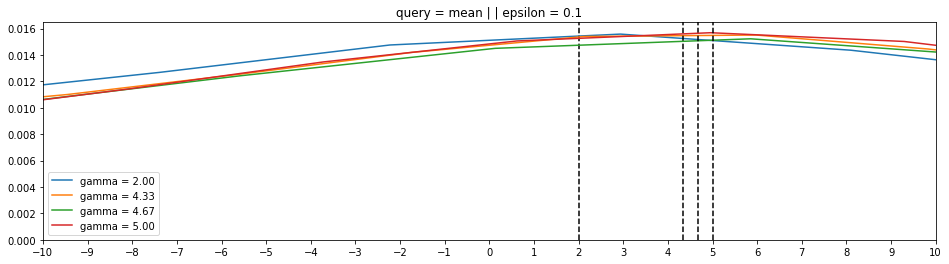

In [751]:
plot_variations_w_epsilon(epsilon=0.1, combinations=combinations, query='mean')

epsilon_value:		 0.01
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


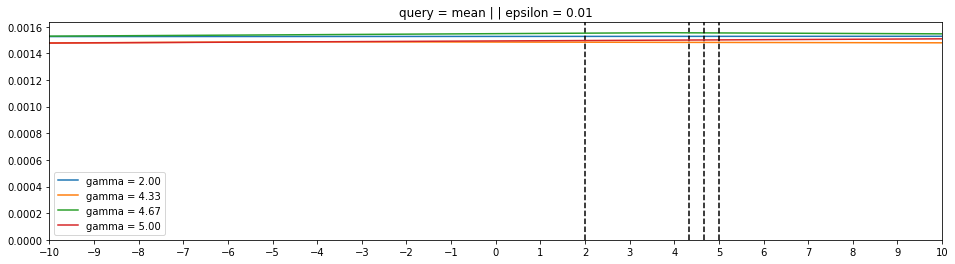

In [752]:
plot_variations_w_epsilon(epsilon=0.01, combinations=combinations, query='mean')

### MEDIAN query for different epsilon values

epsilon_value:		 20
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


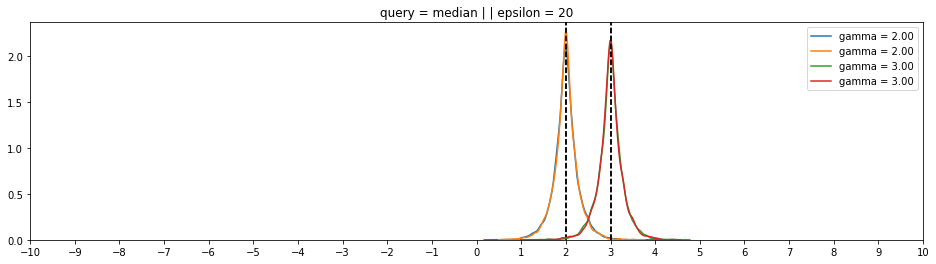

In [1111]:
plot_variations_w_epsilon(epsilon=20, combinations=combinations, query='median')

epsilon_value:		 5
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


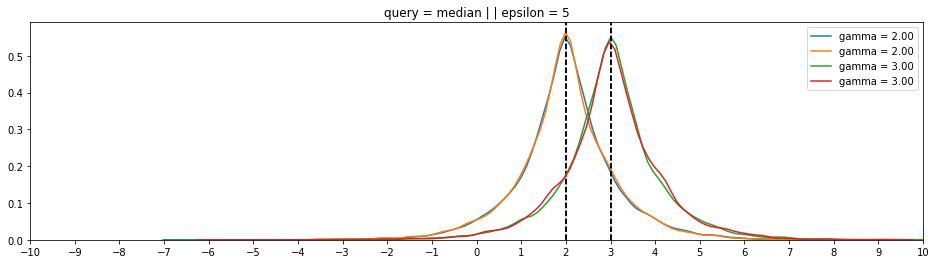

In [1112]:
plot_variations_w_epsilon(epsilon=5, combinations=combinations, query='median')

epsilon_value:		 2
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


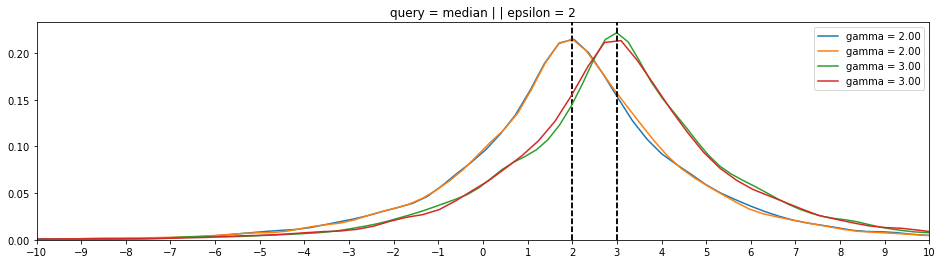

In [1113]:
plot_variations_w_epsilon(epsilon=2, combinations=combinations, query='median')

epsilon_value:		 1
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


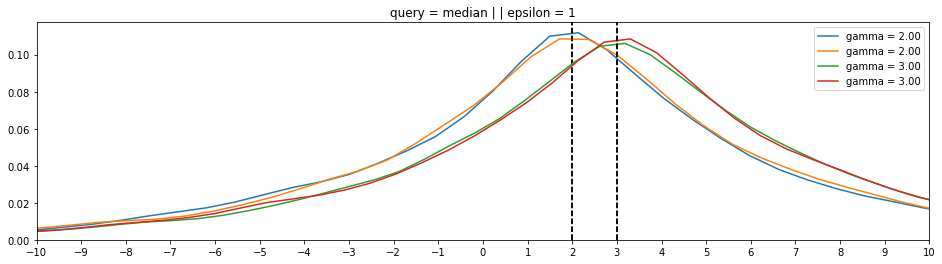

In [1114]:
plot_variations_w_epsilon(epsilon=1, combinations=combinations, query='median')

epsilon_value:		 0.5
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


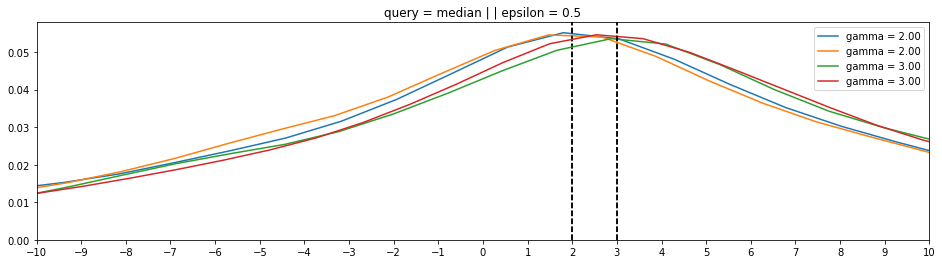

In [1115]:
plot_variations_w_epsilon(epsilon=0.5, combinations=combinations, query='median')

epsilon_value:		 0.1
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


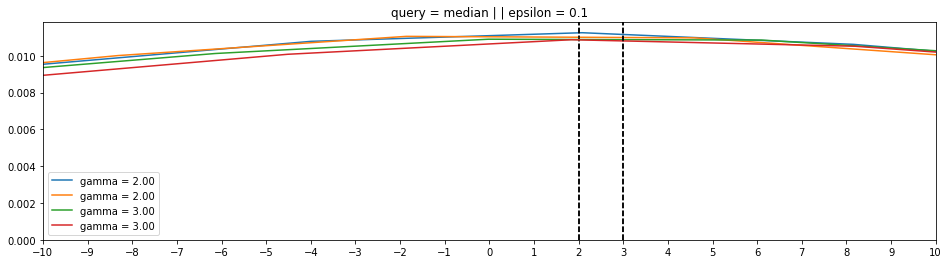

In [1116]:
plot_variations_w_epsilon(epsilon=0.1, combinations=combinations, query='median')

epsilon_value:		 0.01
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


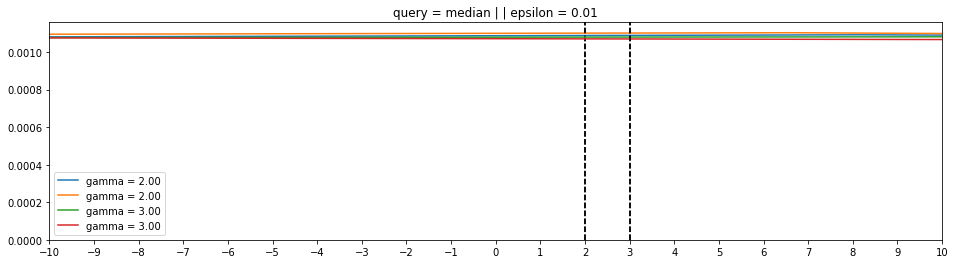

In [1117]:
plot_variations_w_epsilon(epsilon=0.01, combinations=combinations, query='median')

### Posterior Values Generation

In [1281]:
# Mean
get_posterior_table(epsilon_list=[20,5,2,1,0.5,0.1,0.01,0.001], combinations=combinations, real_value=2, query='mean')

global_sensitivity:	 2.833333333333333

Valor real = 2


,epsilon=20,epsilon=5,epsilon=2,epsilon=1,epsilon=0.5,epsilon=0.1,epsilon=0.01,epsilon=0.001
"(1, 2, 3)",9.999999e-01,0.970548,0.682519,0.459577,0.347697,0.268050,0.251769,0.250177
"(1, 2, 10)",7.029337e-08,0.015803,0.131464,0.201699,0.230342,0.246859,0.249704,0.249971
"(1, 3, 10)",6.684132e-09,0.008776,0.103901,0.179313,0.217184,0.243972,0.249410,0.249941
"(2, 3, 10)",6.355879e-10,0.004873,0.082117,0.159411,0.204777,0.241119,0.249117,0.249912
guess_confidence,7.499999e-01,0.720548,0.432519,0.209577,0.097697,0.018050,0.001769,0.000177


epsilon_value:		 5
global_sensitivity:	 2.833333333333333

(1, 2, 3)	-->	query=mean | gamma = 2.00
(1, 2, 10)	-->	query=mean | gamma = 4.33
(1, 3, 10)	-->	query=mean | gamma = 4.67
(2, 3, 10)	-->	query=mean | gamma = 5.00


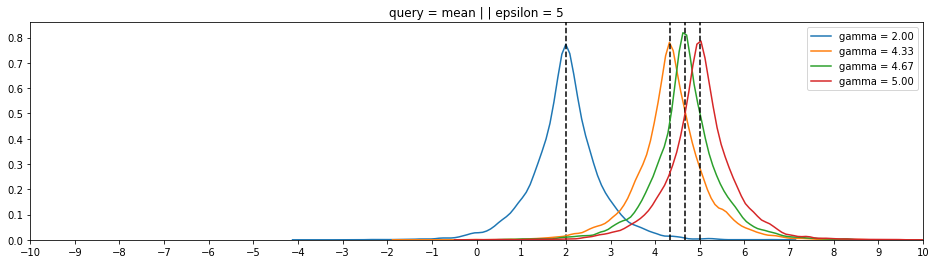

In [1284]:
plot_variations_w_epsilon(epsilon=5, combinations=combinations, query='mean')

In [1282]:
# Median
get_posterior_table(epsilon_list=[20,5,2,1,0.5,0.1,0.01,0.001], combinations=combinations, real_value=2, query='median')

global_sensitivity:	 4.0

Valor real = 2


,epsilon=20,epsilon=5,epsilon=2,epsilon=1,epsilon=0.5,epsilon=0.1,epsilon=0.01,epsilon=0.001
"(1, 2, 3)",0.496654,0.38865,0.31123,0.281088,0.265605,0.253125,0.250312,0.250031
"(1, 2, 10)",0.496654,0.38865,0.31123,0.281088,0.265605,0.253125,0.250312,0.250031
"(1, 3, 10)",0.003346,0.11135,0.18877,0.218912,0.234395,0.246875,0.249688,0.249969
"(2, 3, 10)",0.003346,0.11135,0.18877,0.218912,0.234395,0.246875,0.249688,0.249969
guess_confidence,0.246654,0.13865,0.06123,0.031088,0.015605,0.003125,0.000312,0.000031


epsilon_value:		 5
global_sensitivity:	 4.0

(1, 2, 3)	-->	query=median | gamma = 2.00
(1, 2, 10)	-->	query=median | gamma = 2.00
(1, 3, 10)	-->	query=median | gamma = 3.00
(2, 3, 10)	-->	query=median | gamma = 3.00


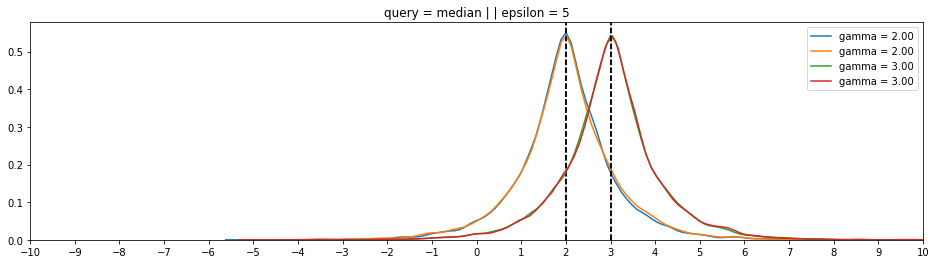

In [1285]:
plot_variations_w_epsilon(epsilon=5, combinations=combinations, query='median')

# 3) Sintetic Data Generation - Iris Dataset

In [782]:
iris = sns.load_dataset('iris')

In [1286]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [1014]:
### Sintetic data generation

def sintethize_feature(serie:pd.Series, epsilon=1, query='mean', plot_noise_universe = False):

    serie_list=list(serie)
    try:
        feature_name = serie.name
    except: 
        feature_name = ''
    ### TODO: It works well for "mean" queries. but it has also to work for others (median, etc). 
    ### When plotting, a big blank appears

    _,__,sensitivity = get_sensitivity_from_serie(serie=serie_list, query=query)
    sensitivity

    annonimity_scale_factor = sensitivity / epsilon

    expected_result = 0 #np.mean(serie)
    if plot_noise_universe:
        plot_random_samples_laplace(mean=expected_result, scale=annonimity_scale_factor, plot=True, 
                                    label=f'{feature_name}',
                                   )
        plt.axvline(x=expected_result, ymin=0, ymax=1, c='b', ls='--')
        plt.annotate(f'{expected_result:.02f}', xy=(expected_result*1.001,2))
        plt.legend(title='Noise added')

    serie_sinthetized = serie.apply(lambda x: x + get_laplace_noise(0, scale=annonimity_scale_factor))
    return serie_sinthetized


def sintethize_dataset(df:pd.DataFrame, exclude_col:list=[], epsilon=1, query='mean', plot_noise_universe=True)->pd.DataFrame:
    sintetic = df.copy()
    
    features_to_sintetize = list(sintetic.select_dtypes(include=['float','float32','float64',
                                                             'Float32','Float64','int','int32',
                                                             'int64','Int32','Int64']))
    for feature in features_to_sintetize:
        sintetic[feature] = sintethize_feature(sintetic[feature], epsilon=epsilon, query=query, plot_noise_universe=plot_noise_universe)
    
    return sintetic

In [1287]:
plt.rcParams['figure.figsize']=(10,4)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.157046,3.498010,1.386493,0.197382,setosa
1,4.899776,2.997976,1.401540,0.204492,setosa
2,4.698708,3.223202,1.326580,0.156917,setosa
3,4.629191,3.102777,1.482811,0.197606,setosa
4,4.994471,3.623654,1.273132,0.192440,setosa


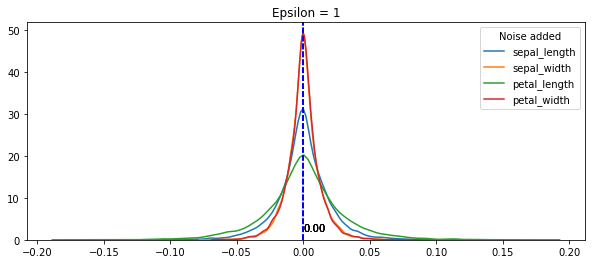

In [1288]:
epsilon = 1
iris_sintetic_1 = sintethize_dataset(iris, query='mean', epsilon=epsilon)
plt.title(f'Epsilon = {epsilon}');
iris_sintetic_1.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.124298,3.456685,1.988806,-0.133219,setosa
1,4.888343,2.829980,1.392491,0.174427,setosa
2,4.800127,3.251831,1.319762,0.230898,setosa
3,4.598316,3.282278,1.583952,0.233742,setosa
4,5.127794,3.562013,1.400673,0.229106,setosa


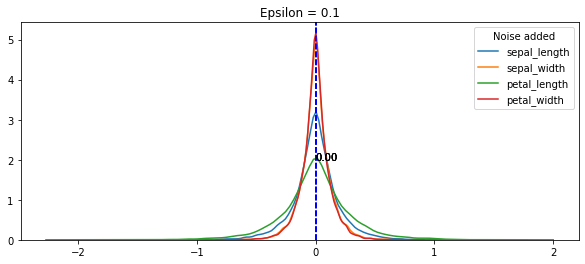

In [1289]:
epsilon = 0.1
iris_sintetic_2 = sintethize_dataset(iris, query='mean', epsilon=epsilon)
plt.title(f'Epsilon = {epsilon}');
iris_sintetic_2.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,11.249952,2.426768,0.199930,0.477528,setosa
1,3.154510,4.700942,2.191717,-0.458857,setosa
2,4.066377,3.213136,3.490089,0.532818,setosa
3,3.393680,3.599155,4.885532,0.378459,setosa
4,4.562241,1.195494,-0.227220,0.554687,setosa


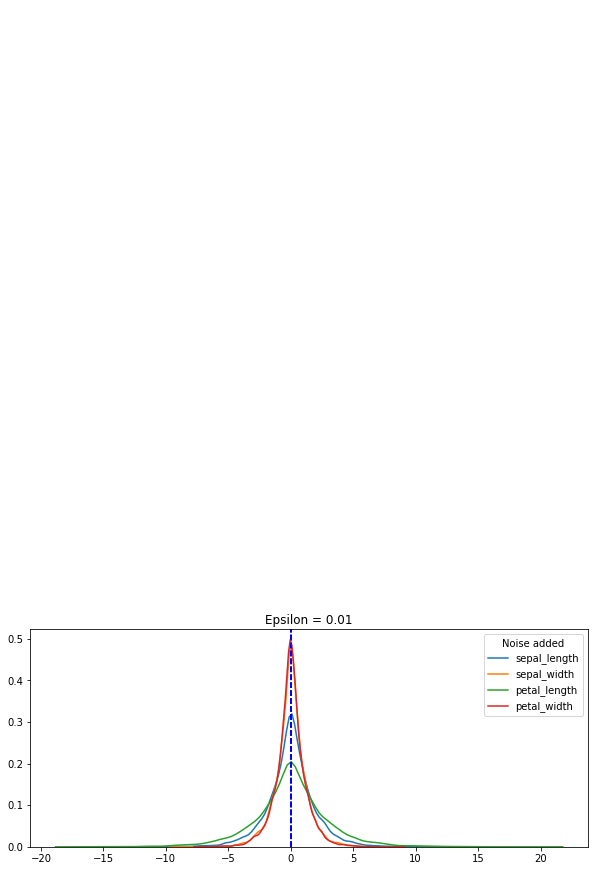

In [1290]:
epsilon = 0.01
iris_sintetic_3 = sintethize_dataset(iris, query='mean', epsilon=epsilon)
plt.title(f'Epsilon = {epsilon}');
iris_sintetic_3.head()

In [1291]:
columna = 'sepal_length'
for columna in ['sepal_length','sepal_width','petal_length','petal_width']:
    print(f'\nMean {columna}')
    print(f'''iris_base:\t\t{iris[columna].mean():.04f}''')
    print(f'''iris_sintetic_1.00:\t{iris_sintetic_1[columna].mean():.04f}''')
    print(f'''iris_sintetic_0.10:\t{iris_sintetic_2[columna].mean():.04f}''')
    print(f'''iris_sintetic_0.01:\t{iris_sintetic_3[columna].mean():.04f}''')


Mean sepal_length
iris_base:		5.8433
iris_sintetic_1.00:	5.8421
iris_sintetic_0.10:	5.8493
iris_sintetic_0.01:	5.9139

Mean sepal_width
iris_base:		3.0573
iris_sintetic_1.00:	3.0556
iris_sintetic_0.10:	3.0666
iris_sintetic_0.01:	3.0986

Mean petal_length
iris_base:		3.7580
iris_sintetic_1.00:	3.7574
iris_sintetic_0.10:	3.7433
iris_sintetic_0.01:	3.5642

Mean petal_width
iris_base:		1.1993
iris_sintetic_1.00:	1.1991
iris_sintetic_0.10:	1.2044
iris_sintetic_0.01:	1.0843
